In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [6]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import esm
import biotite.structure.io as bsio
from collections import defaultdict

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/sabdab")
SABDAB_SUMMARY_PATH = base_path / Path("HLchain_evaluation.tsv")
OUTPUT_PDB = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("chothia")
OUTPUT_SUMMARY = base_path / Path("HLchain_evaluations.tsv")

os.makedirs(OUTPUT_PDB, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PDB}")

Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/sabdab/HLchain_evaluation.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/sabdab/chothia
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/sabdab/predicted_structures


In [7]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df.head(5)

Entries in summary: 32,913


,pdb,chain,chain_type,sequence,resolution,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after,length,LDDT_before
0,8ykd,S,Hchain,VQLVESGGGLVQPGGSRKLSCSASGFAFSSFGMHWVRQAPEKGLEWVAYISSGSGTIYYADTVKGRFTISRDDPKNTLFLQMTSLRSEDTAMYYCV...,2.9,83.441442,NaN,NaN,NaN,NaN,NaN,233,NaN
1,8ykd,s,Lchain,DIVMTQATSSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPGQSPQLLIYRMSNLASGVPDRFSGSGSGTAFTLTISRLEAEDVGVYYCMQH...,2.9,89.154623,NaN,NaN,NaN,NaN,NaN,111,NaN
2,8ykd,N,Hchain,QVQLQESGGGLVQPGGSLRLSCAASGFTFSNYKMNWVRQAPGKGLEWVSDISQSGASISYTGSVKGRFTISRDNAKNTLYLQMNSLKPEDTAVYYC...,2.9,83.731851,NaN,NaN,NaN,NaN,NaN,127,NaN
3,9eje,H,Hchain,LVKPSETLSLTCSVSGESISSGGYYWTWIRQHPGKGLEWIGNIFDTGSTHYSPSLKTRLTISIDTSKNQFYLRLNSATAADTAVYYCARVGYSLET...,4.18,80.446852,NaN,NaN,NaN,NaN,NaN,117,NaN
4,9eje,L,Lchain,DIVMTQSPLSLPVTPGEPASISCRSSQSLLHSNGYTYLDWYLQKPGQSPQLLIYLASNRASGVPDRFSGSGSGTYFTLKISRVEAEDVGVYYCMQA...,4.18,89.447657,NaN,NaN,NaN,NaN,NaN,112,NaN


In [8]:
df['difference'] = df['pLDDT_after'] - df['pLDDT_before']
df.difference.describe()

count    222.000000
mean       6.300816
std        5.033046
min        0.000000
25%        3.015463
50%        5.426710
75%        7.917203
max       33.487034
Name: difference, dtype: float64

In [30]:
sub_df = df.query("pLDDT_after.notna()")
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    814.000000
 mean      38.777896
 std       16.883286
 min       19.979411
 25%       23.866801
 50%       30.711519
 75%       54.325428
 max       69.924061
 Name: pLDDT_before, dtype: float64,
 count    814.000000
 mean      46.651283
 std       16.242151
 min       21.227891
 25%       32.292397
 50%       42.332474
 75%       61.736369
 max       82.658511
 Name: pLDDT_after, dtype: float64)

In [31]:
df['diff_plddt'] = df['pLDDT_after'] - df['pLDDT_before']

In [32]:
df.query("diff_plddt > 10").tm_score_before.describe(), df.query("diff_plddt > 10").tm_score_after.describe()

(count    245.000000
 mean       0.340882
 std        0.114327
 min        0.151880
 25%        0.269710
 50%        0.301270
 75%        0.375210
 max        0.806740
 Name: tm_score_before, dtype: float64,
 count    245.000000
 mean       0.370451
 std        0.167333
 min        0.139250
 25%        0.270580
 50%        0.312430
 75%        0.375930
 max        0.922660
 Name: tm_score_after, dtype: float64)

In [19]:
sub_df = df.query("diff_plddt > 20")

In [7]:
df.query("pLDDT_after.notna()").shape[0]

814

In [45]:
# from proteinttt.utils.parsers import fetch_and_parse_sequences
# df_new = fetch_and_parse_sequences(df, PDB_FILES_PATH)
# df_new.drop_duplicates(subset=['pdb', 'chain'], inplace=True)
# df_old.drop_duplicates(subset=['pdb', 'chain'], inplace=True)
# df_new.to_csv(path_or_buf=base_path / "summary_try.tsv", sep="\t", index=False)

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

In [ ]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PDB):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    out_path = out_dir / f"{pdb_id}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())
    
    # try:
    #     tm_score = calculate_tm_score(
    #         pred_path=out_path,
    #         pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    # except Exception as e:
    #     print(f"Could not calculate TM-score for {pdb_id}: {e}")
    #     tm_score = np.nan
        
    # try:
    #     lddt = lddt_score(pdb_ref=PDB_FILES_PATH / f"{pdb_id}.pdb", pdb_model=out_path)
    # except Exception as e:
    #     # print(f"Could not calculate lDDT for {pdb_id}: {e}")
    #     lddt = np.nan
    
    return pLDDT, np.nan, np.nan

In [ ]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PDB):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    model.ttt(sequence)
    pLDDT_after, tm_score_after, lddt = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after, tm_score_after, lddt

## Before

In [10]:
num_of_low = 0
col = 'sequence'

In [28]:
existing_seqs_before = defaultdict(list)

for i, row in df.iterrows():
    if pd.isna(row["pLDDT_before"]):
        continue
    
    seq = str(row[col]).strip().upper()
    pdb_id = str(row.get("pdb"))
    tag = row["chain"]
    if seq not in existing_seqs_before:
        existing_seqs_before[seq] = [i, row["pLDDT_before"], row["tm_score_before"], 1]
    else:
        existing_seqs_before[seq][3] += 1
    

In [ ]:
for i, row in df.iterrows():
    if pd.isna(row["pLDDT_before"]):
        continue

    seq = str(row[col]).strip().upper()
    pdb_id = str(row.get("pdb"))
    tag = row["chain"]
    if seq not in existing_seqs_before:
        existing_seqs_before[seq] = [i, row["pLDDT_before"], row["tm_score_before"], 1]
    else:
        existing_seqs_before[seq][3] += 1

In [ ]:
import time
from tqdm import tqdm
c=0
start_time = time.time()

for i, row in df.iterrows():
    if pd.isna(row[col]) or pd.notna(row['pLDDT_before']) or row['length'] > 400:
        continue
    c+=1
    pdb_id = str(row.get("pdb"))
    
    seq = str(row[col]).strip().upper()
    tag = row["chain"]
    
    # if seq in existing_seqs_before:
    #     print(f"Sequence exists for {pdb_id}, copying results")
    #     _, pLDDT_before, tm_score_before, _ = existing_seqs_before[seq]
    #     df.at[i, 'pLDDT_before'] = pLDDT_before
    #     df.at[i, 'tm_score_before'] = tm_score_before
    #     df.at[i, 'LDDT_before'] = np.nan
    #     existing_seqs_before[seq][3] +=1
    #     continue

    # if (OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb").exists():
    #     print(f"File {pdb_id} exists")
    #     struct = bsio.load_structure(OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb", extra_fields=["b_factor"])
    #     pLDDT_before = float(np.asarray(struct.b_factor, dtype=float).mean())
    #     try:
    #         tm_score_before = calculate_tm_score(
    #             pred_path=OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb",
    #             pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    #     except Exception as e:
    #         print(f"Could not calculate TM-score for {pdb_id}: {e}")
    #         tm_score_before = np.nan
    #     lddt_before = np.nan
    # else:
    try:
        pLDDT_before, tm_score_before, lddt_before = predict_structure(model, seq, pdb_id, tag=f'{tag}_before_ttt', out_dir=OUTPUT_PDB)
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag}: {e}")
        continue
        
    df.at[i, f'pLDDT_before'] = pLDDT_before
    df.at[i, f'tm_score_before'] = tm_score_before
    df.at[i, 'LDDT_before'] = lddt_before
    
    existing_seqs_before[seq] = [i, pLDDT_before, tm_score_before, 1]
    
    if pLDDT_before < 70:
        num_of_low+=1
        print(pLDDT_before)
        df.to_csv(SABDAB_SUMMARY_PATH, sep="\t", index=False)
        print(f"Total time elapsed: {time.time() - start_time:.2f} seconds for {c} sequences")

            
df.to_csv(SABDAB_SUMMARY_PATH, sep="\t", index=False)
print(num_of_low)

## After

In [ ]:
existing_seqs_after = defaultdict(list)

for i, row in df.iterrows():
    if pd.isna(row["pLDDT_after"]):
        continue

    seq = str(row[col]).strip().upper()
    pdb_id = str(row.get("pdb"))
    tag = row["chain"]
    if seq not in existing_seqs_after:
        existing_seqs_after[seq] = [i, row["pLDDT_after"], row["tm_score_after"], 1]
    else:
        existing_seqs_after[seq][3] += 1

In [ ]:
for i, row in df.iterrows():
    if pd.isna(row["pLDDT_after"]):
        continue

    seq = str(row[col]).strip().upper()
    pdb_id = str(row.get("pdb"))
    tag = row["chain"]
    if seq not in existing_seqs_after:
        existing_seqs_after[seq] = [i, row["pLDDT_after"], row["tm_score_after"], 1]
    else:
        existing_seqs_after[seq][3] += 1

In [ ]:
c = 0
start_time = time.time()
for i, row in df.iterrows():
    # if row['pLDDT_before'] > 70 or pd.isna(row.get("pLDDT_before")) or row['length'] > 400 or (pd.notna(row.get("pLDDT_after"))):
    #     continue
    
    pdb_id = str(row.get("pdb"))

    if pd.isna(row[col]):
        continue
    
    tag = row["chain"]
    seq = str(row[col]).strip().upper()
    
    if seq in existing_seqs_after:
        # print(f"Sequence exists for {pdb_id}, copying results")
        _, pLDDT_after, tm_score_after, _ = existing_seqs_after[seq]
        df.at[i, 'pLDDT_after'] = pLDDT_after
        df.at[i, 'tm_score_after'] = tm_score_after
        df.at[i, 'LDDT_after'] = np.nan
        existing_seqs_after[seq][3] +=1
        continue

    # if (OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb").exists():
    #     print(f"File {pdb_id} exists")
    #     struct = bsio.load_structure(OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb", extra_fields=["b_factor"])
    #     pLDDT_after = float(np.asarray(struct.b_factor, dtype=float).mean())
    #     try:
    #         tm_score_after = calculate_tm_score(
    #             pred_path=OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb",
    #             pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    #     except Exception as e:
    #         print(f"Could not calculate TM-score for {pdb_id}: {e}")
    #         tm_score_after = np.nan
    #     lddt_score = np.nan
    # else:
    try:
        pLDDT_after, tm_score_after, lddt_score = fold_chain(seq, pdb_id, model=model, tag=row["chain"])
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag}: {e}")
        pLDDT_after, tm_score_after, lddt_score = np.nan, np.nan, np.nan

    c += 1
    df.at[i, 'pLDDT_after'] = pLDDT_after
    df.at[i, 'tm_score_after'] = tm_score_after
    df.at[i, 'LDDT_after'] = lddt_score
            
    existing_seqs_after[seq] = [i, pLDDT_after, tm_score_after, 1]
    if c % 10 == 0:
        break
        # df.to_csv(OUTPUT_SUMMARY, sep="\t", index=False)
        
print(f"Total time elapsed: {time.time() - start_time:.2f} seconds for {c} sequences")

df.to_csv(OUTPUT_SUMMARY, sep="\t", index=False)

## Plots

Entries with pLDDT before and after: 814


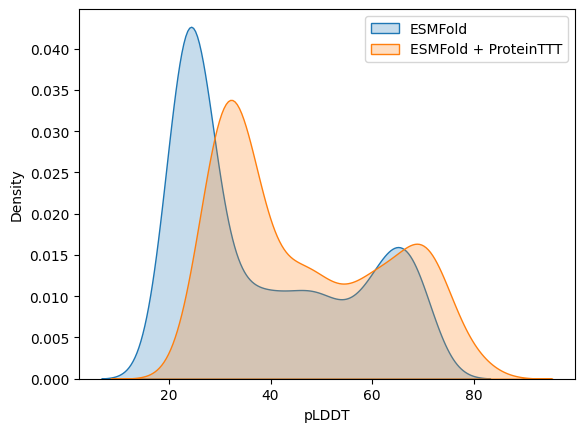

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

Entries with pLDDT before and after: 222


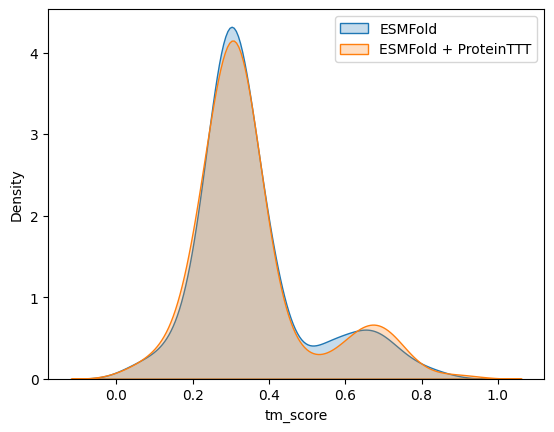

In [11]:
sub_df = df.query("tm_score_before.notna() and tm_score_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

Entries with pLDDT before and after: 176


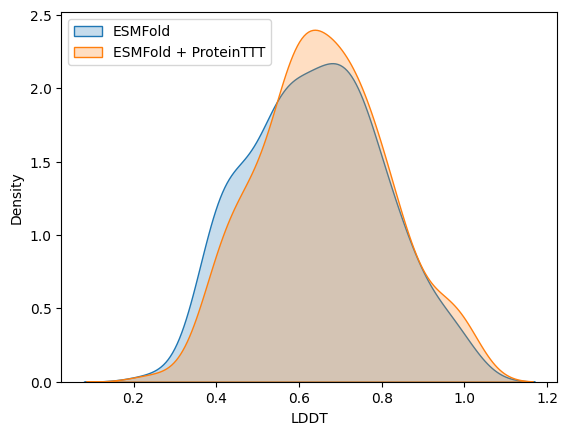

In [22]:
# sub_df = df.query("lddt_before.notna() and lddt_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['lddt_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['lddt_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('LDDT')
plt.legend()
plt.show()

In [28]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe(), sub_df.tm_score_before.describe(), sub_df.tm_score_after.describe(), sub_df.lddt_before.describe(), sub_df.lddt_after.describe()

(count    814.000000
 mean      38.777896
 std       16.883286
 min       19.979411
 25%       23.866801
 50%       30.711519
 75%       54.325428
 max       69.924061
 Name: pLDDT_before, dtype: float64,
 count    814.000000
 mean      46.651283
 std       16.242151
 min       21.227891
 25%       32.292397
 50%       42.332474
 75%       61.736369
 max       82.658511
 Name: pLDDT_after, dtype: float64,
 count    814.000000
 mean       0.386145
 std        0.175964
 min        0.026600
 25%        0.269330
 50%        0.312685
 75%        0.459685
 max        0.895360
 Name: tm_score_before, dtype: float64,
 count    814.000000
 mean       0.397734
 std        0.187369
 min        0.029990
 25%        0.271375
 50%        0.323690
 75%        0.486305
 max        0.922660
 Name: tm_score_after, dtype: float64,
 count    814.000000
 mean       0.422807
 std        0.188993
 min        0.196656
 25%        0.265845
 50%        0.320061
 75%        0.566979
 max        0.977778
 Name: l

/tmp/ipykernel_3880426/3737630287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['diff'] = sub_df['lddt_after'] - sub_df['lddt_before']


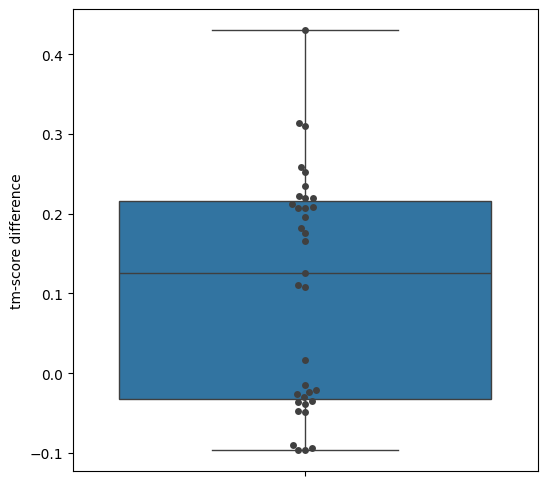

In [21]:
sub_df['diff'] = sub_df['lddt_after'] - sub_df['lddt_before']
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df['diff'])
sns.swarmplot(data=sub_df['diff'], color=".25")
plt.ylabel('tm-score difference')
# plt.xticks([0, 1], ['ESMFold'])
plt.show()

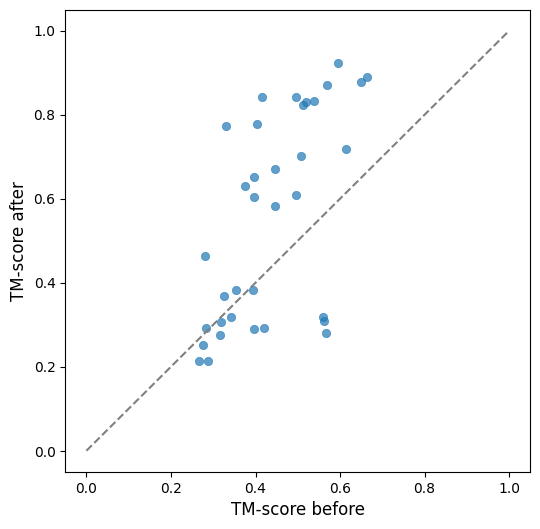

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['tm_score_before'], sub_df['tm_score_after'], alpha=0.7, linewidths=0.5)

ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("TM-score before", fontsize=12)
ax.set_ylabel("TM-score after", fontsize=12)
# ax.set_title("Comparison of TM-score Before and After Refinement", fontsize=14)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_aspect('equal', adjustable='box')

# cbar = fig.colorbar(sc)
# cbar.set_label("Improvement (TM-score after - before)", fontsize=12)

# ax.grid(True, linestyle='--', alpha=0.6)

# plt.tight_layout()
plt.show()

1

In [42]:
# plt.figure(figsize=(10, 6))
# # sns.scatterplot(x='Hchain_pLDDT_before', y='Hchain_tm_score_before', data=df, label='ESMFold', alpha=0.5)
# sns.scatterplot(x='Hchain_pLDDT_after', y='Hchain_tm_score_after', data=df, label='ESMFold + ProteinTTT', alpha=0.5)
# plt.xlabel('pLDDT')
# plt.ylabel('TM-score')
# plt.legend()
# plt.show()

In [ ]:
# rows = df.dropna(subset=['Hchain_pLDDT_before', 'Hchain_tm_score_before'])
# from scipy.stats import pearsonr
# pearsonr(rows['Hchain_pLDDT_after'], rows['Hchain_tm_score_after'])

In [43]:
# df['Hchain_tm_score_diff'] = df['Hchain_tm_score_after'] - df['Hchain_tm_score_before']
# plt.figure(figsize=(4, 5))
# plt.scatter(np.zeros_like(df['Hchain_tm_score_diff']), df['Hchain_tm_score_diff'], color='green')
# plt.ylabel('TM-score difference after and before ProteinTTT')

In [24]:
df['diff'] = df['tm_score_after'] - df['tm_score_before']
top_10_diff = df.nlargest(10, 'diff')
top_10_diff

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after,diff
62,9jie,B,33.62,60.79,0.32913,0.77222,0.324819,0.635456,0.44309
1290,8pww,A,41.09,72.51,0.41465,0.84147,0.468381,0.687995,0.42682
1091,8qks,A,39.49,69.77,0.40257,0.77777,0.428162,0.610752,0.37520
2114,8ezm,A,53.54,78.33,0.49518,0.84132,0.627589,0.834525,0.34614
1151,8x7n,A,50.54,84.21,0.59457,0.92266,0.410223,0.840621,0.32809
1090,8qkr,A,40.63,71.20,0.51352,0.82431,0.449916,0.662177,0.31079
1015,8soz,A,51.09,80.12,0.51991,0.83034,0.459287,0.667672,0.31043
1002,9jbq,C,49.16,85.11,0.56830,0.87030,0.528047,0.842539,0.30200
1014,8sow,A,51.11,74.63,0.53775,0.83209,0.476505,0.683961,0.29434
1161,8pn0,E,35.74,62.33,0.37521,0.63004,0.338393,0.590708,0.25483
